The purpose of this notebook is to pre-process all our data, which prevents us from having to import it every time we run a new instance of the main notebook. That way, it will be a lot more time-efficient to code in the main notebook.

In [2]:
%env PYTHONHASHSEED 3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

env: PYTHONHASHSEED=3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from math import sqrt
import pyspark
import os
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName('Twitter Analysis').config(
    "spark.executor.memory", "1g").config("spark.ui.port", "4050"
        ).getOrCreate()
sc = spark.sparkContext

#Mounting our Google Drive in order to retrieve pre-processed files
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

#The 10 most influential users from the output of our PageRank algorithm.
influential_users = ['15924858', '14719129', '53235381', '11928542', '215824411', '90880254', '18996905', '262310943', '100318079', '24542441']

#Reads in pre-processed files from my drive, first one as an RDD, second as a dataframe (as the file isn't very large, and we want to convert it into a dictionary)
featnames_rdd = sc.textFile('/content/drive/My Drive/twitter_analysis/grouped_features.txt')
text_feat_dict = spark.read.text('/content/drive/MyDrive/twitter_analysis/features_dictionary.txt')

Mounted at /content/drive


In [4]:
#Converts the single column dataframe (with values stored as key:value) into a dataframe with two columns, key and value (key being the index of the feature, and value being the feature)
df_feat_dict = text_feat_dict.selectExpr("split(value, ':') as kv").selectExpr("kv[0] as key", "kv[1] as value")
#Converts the dataframe into a dictionary
feature_dictionary = {row['key']: int(row['value']) for row in df_feat_dict.collect()}
#Sorts the keys, just for ease of comparison when testing
feature_dictionary = dict(sorted(feature_dictionary.items(), key=lambda item: item[1]))
print(feature_dictionary)

{'@CaitlinDyess': 0, '#BlackOps2': 1, '#theresnog': 2, '@mateospag': 3, '@caseymckinnon': 4, '@PDelahanty': 5, '#BestInTheWorld': 6, '@hayleybr.com': 7, '@ConfusedLush': 8, '@WWE': 9, '@Paramore_FC_BR': 10, '@_zigga': 11, '@TheGoGame': 12, '@BrodusClay': 13, '@TheCakeWolf': 14, '#TeamBringIt': 15, '@Spotify': 16, '@hayleyporra': 17, '@JustinRYoung': 18, '@TwittaParamore': 19, '@paramonsters': 20, '@matheusthierre': 21, '@romanymalco': 22, '@Shibby2142': 23, '@FuzzyOtterBalls': 24, '#Blops2': 25, '@chzbizman': 26, '@CrashKinkaide': 27, '@lonelysandwich': 28, '@miamiherald': 29, '@MilanMiracle': 30, '@GuildWars2': 31, '@thebellatwins': 32, '@Rubi_': 33, '#SMH': 34, '@DavidVonderhaar': 35, '@TONERAPS': 36, '#VersaEmerge': 37, '@GetGlue': 38, '@invisiblewife': 39, '@ebertchicago': 40, '#GW2beta': 41, '@SublimeWithRome': 42, '@EvilGeniusHD': 43, '@LiveForHayley': 44, '@curley': 45, '@verge)': 46, '@tcpow': 47, '@CalgaryGuru': 48, '@TWiT’s': 49, '#WM28': 50, '@fueledbyramen.com': 51, '@iyaz'

In [5]:
excess = "'( ,)"
feature_necessary = ['#', '@']

#Removes dud features that have been accidentally included in the RDD as a result of
#string formatting.
def remove_duds(a_list):
  output = []
  for item in a_list:
    if len(item) > 1 and item[0] in feature_necessary:
      output.append(item)
  return output

grouped_featnames = featnames_rdd.map(lambda x: (x.split('[')[0].strip(excess), x.split('[')[1].split("'"))).map(lambda x: (x[0], remove_duds(x[1])))
#The above converts our RDD from the imported text version, into the grouped version that we generated in the preprocessing file
grouped_featnames.take(5)

In [6]:
from pyspark.ml.linalg import Vectors

def generate_vector(full_feat_dict, input_list):
  """Function to generate a sparse vector from a list of user profile features, by comparing
  it to the dictionary containing the features of another profile"""
  output = []
  for item in full_feat_dict.keys():
    if item in input_list:
      output.append(1)
    else:
      output.append(0)
  return Vectors.sparse(len(output), [(i, value) for i, value in enumerate(output)])
#The output of this function is a sparse vector, representing whether or not a user's profile feature is
#contained within another user's dictionary of profile features. This is then used as
#the input for our cosine similarity calculation.

sparse_feat_vectors_rdd = grouped_featnames.map(lambda x: (x[0], generate_vector(feature_dictionary, x[1])))
sparse_feat_vectors_rdd.persist()
sparse_feat_vectors_rdd.take(5)

PythonRDD[6] at RDD at PythonRDD.scala:53

In [7]:
import math

def generate_similarities(main_rdd):
  """Function to generate cosine similarity values of every combination of our 
  top 10 most influential users. We loop through every influential user in the list,
  with each user being used as a baseline for features - which are then used to be compared with
  the features of every other influential user. We do this by first initialising the sparse vector
  of the baseline, and comparing it to every other sparse vector of features in the """
  output = []
  for i in range(0, len(influential_users)):
    base_rdd = main_rdd.filter(lambda x: x[0] == influential_users[i]).map(lambda x: x[1]).collect()[0]
    base_sv = Vectors.sparse(len(base_rdd), [(i, value) for i, value in enumerate(base_rdd)])
    similarities_rdd = main_rdd.map(lambda x: (x[0], influential_users[i], cosine_similarity(base_sv, x[1])))
    similarities = similarities_rdd.collect()
    output.append(similarities)
  return output

#This is James' function from his email regarding cosine similarity.
def cosine_similarity(x, y):
  """
  Computes cosine similarity on spark ML SparseVectors x and y
  """
  #multiplication of two 1's is a 1, anything else is a 0, so bitset dot product
  # is equivalent to bitwise and followed by a count of all nonzero elements
  dot_product = x.dot(y)
  #magnitude is sqrt(sum of squares), square of 0 is 0 and square of 1 is 1, 
  #so sum of squares for us is equivalent to count of all nonzero elements
  mag_x = sqrt(x.numNonzeros())
  mag_y = sqrt(y.numNonzeros())
  return dot_product / (mag_x*mag_y)


In [8]:
cosine_similarities = generate_similarities(sparse_feat_vectors_rdd)
sparse_feat_vectors_rdd.unpersist()

PythonRDD[6] at RDD at PythonRDD.scala:53

In [15]:
#Just quick and simple code to display the results from our analysis.
#I've chosen the threshold of significance to be 0.4, due to the nature of our dataset.
#The reasoning behind that decision is articulated in my project report.
similar_users = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] > 0.4 and item[1] != item[0]:
      similar_users.append(item)
print(similar_users)


nonsimilar_users = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] < 0.4 and item[1] != item[0]:
      nonsimilar_users.append(item)


similar_proportion = len(similar_users) / (len(nonsimilar_users) + len(similar_users))
nonsimilar_proportion = 1 - similar_proportion
print(similar_proportion)
print(nonsimilar_proportion)

[('90880254', '14719129', 0.44474958999666064), ('53235381', '14719129', 0.5194113811148742), ('14719129', '53235381', 0.5194113811148742), ('90880254', '53235381', 0.6142712695109416), ('14719129', '90880254', 0.44474958999666064), ('53235381', '90880254', 0.6142712695109416), ('100318079', '18996905', 0.5336000974881928), ('18996905', '100318079', 0.5336000974881928)]
0.08888888888888889
0.9111111111111111


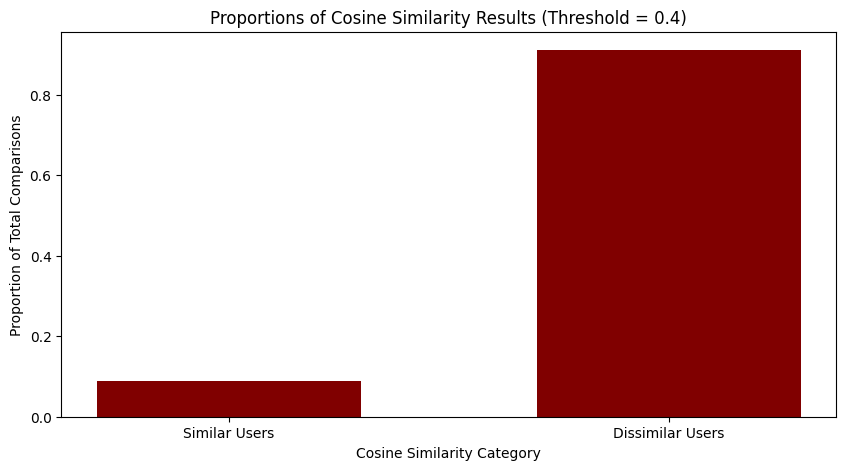

In [16]:
import matplotlib.pyplot as plt
import numpy as np
x = ["Similar Users", "Dissimilar Users"]
y = [similar_proportion, nonsimilar_proportion]
fig = plt.figure(figsize = (10, 5))

plt.bar(x, y, color ='maroon',
        width = 0.6)
 
plt.xlabel("Cosine Similarity Category")
plt.ylabel("Proportion of Total Comparisons")
plt.title("Proportions of Cosine Similarity Results (Threshold = 0.4)")
plt.show()

In [11]:
similar_users2 = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] > 0.1 and item[1] != item[0]:
      similar_users2.append(item)
print(similar_users2)

nonsimilar_users2 = []
for i in range(0, len(cosine_similarities)):
  for item in cosine_similarities[i]:
    if item[2] < 0.1 and item[1] != item[0]:
      nonsimilar_users2.append(item)
print(nonsimilar_users2)

similar_proportion2 = len(similar_users2) / (len(nonsimilar_users2) + len(similar_users2))
nonsimilar_proportion2 = 1- similar_proportion2
print(similar_proportion2)
print(nonsimilar_proportion2)

[('11928542', '14719129', 0.11322770341445956), ('90880254', '14719129', 0.44474958999666064), ('53235381', '14719129', 0.5194113811148742), ('14719129', '53235381', 0.5194113811148742), ('11928542', '53235381', 0.10425720702853737), ('90880254', '53235381', 0.6142712695109416), ('14719129', '11928542', 0.11322770341445956), ('18996905', '11928542', 0.13130643285972254), ('100318079', '11928542', 0.11952286093343936), ('90880254', '11928542', 0.10910894511799617), ('24542441', '11928542', 0.10206207261596574), ('53235381', '11928542', 0.10425720702853737), ('14719129', '90880254', 0.44474958999666064), ('11928542', '90880254', 0.10910894511799617), ('53235381', '90880254', 0.6142712695109416), ('100318079', '18996905', 0.5336000974881928), ('11928542', '18996905', 0.13130643285972254), ('18996905', '100318079', 0.5336000974881928), ('11928542', '100318079', 0.11952286093343936)]
[('14719129', '15924858', 0.0), ('18996905', '15924858', 0.0), ('100318079', '15924858', 0.0), ('262310943',

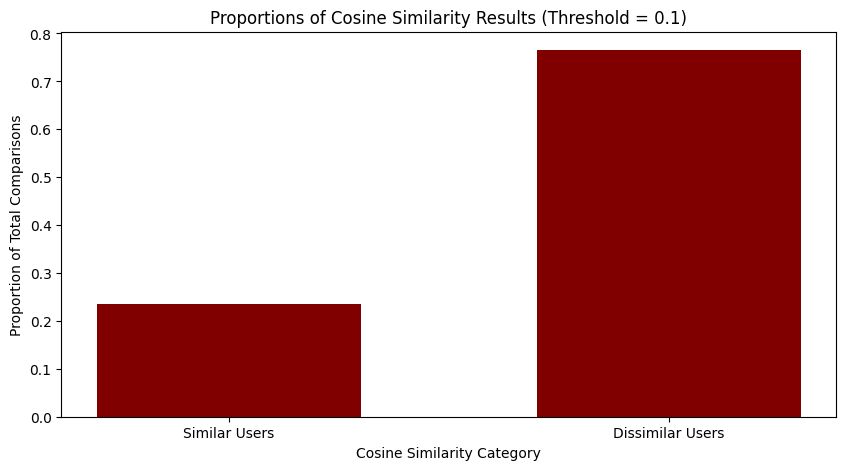

In [12]:
import matplotlib.pyplot as plt
import numpy as np
x = ["Similar Users", "Dissimilar Users"]
y = [similar_proportion2, nonsimilar_proportion2]
fig = plt.figure(figsize = (10, 5))

plt.bar(x, y, color ='maroon',
        width = 0.6)
 
plt.xlabel("Cosine Similarity Category")
plt.ylabel("Proportion of Total Comparisons")
plt.title("Proportions of Cosine Similarity Results (Threshold = 0.1)")
plt.show()